## Wygeneruj dataset

In [142]:
import numpy as np
import pandas as pd

# Generowanie danych wejściowych
np.random.seed(42)
n_orders = 4
n_trucks = 1
n_stations = 10

# Zamówienia: lokalizacja i waga
df_orders = pd.DataFrame({
    "latitude": np.random.randn(n_orders) * 50,
    "longitude": np.random.randn(n_orders) * 50,
    "mass": np.random.rand(n_orders) * 10
})

# Stacje benzynowe: lokalizacja i cena za litr
df_stations = pd.DataFrame({
    "latitude": np.random.randn(n_stations + 2) * 50,
    "longitude": np.random.randn(n_stations + 2) * 50,
    "price": np.random.rand(n_stations + 2) * 2 + 5
})

# Parametry
fuel_consumption = lambda m: m/100  # Spalanie na 100km w zależności od masy
fuel_tank_capacity = 150  # Pojemność baku
base_location = np.array([0, 0])  # Lokalizacja bazy
# average_speed = 40  # Średnia prędkość w km/h
# driver_hourly_rate = 50  # Godzinna stawka kierowcy

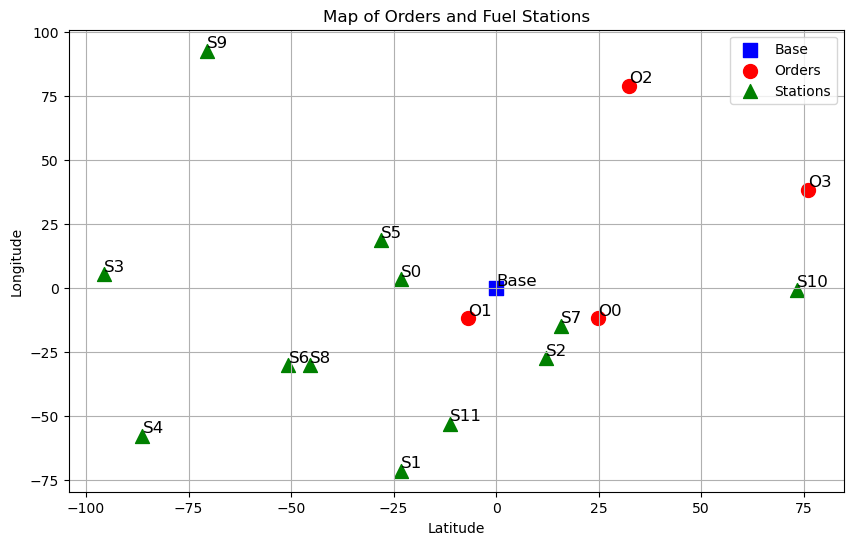

In [143]:
import matplotlib.pyplot as plt
# import pandas as pd

# Adding index as labels

# Plot orders and stations on a map
plt.figure(figsize=(10, 6))

# Plot base location
plt.scatter(base_location[0], base_location[1], c='blue', label='Base', s=100, marker='s')
plt.text(base_location[0], base_location[1], 'Base', fontsize=12, verticalalignment='bottom')

# Plot orders
plt.scatter(df_orders['latitude'], df_orders['longitude'], c='red', label='Orders', s=100, marker='o')
for i, row in df_orders.iterrows():
    plt.text(row['latitude'], row['longitude'], f'O{row.name}', fontsize=12, verticalalignment='bottom')
    
# Plot stations
plt.scatter(df_stations['latitude'], df_stations['longitude'], c='green', label='Stations', s=100, marker='^')
for i, row in df_stations.iterrows():
    plt.text(row['latitude'], row['longitude'], f'S{row.name}', fontsize=12, verticalalignment='bottom')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Map of Orders and Fuel Stations')
plt.legend()
plt.grid(True)
plt.show()


In [144]:
import string

# Generate a list of letters
letter_index = list(string.ascii_uppercase[:len(df_orders)])
df_orders.index = letter_index

df_orders.head()


,latitude,longitude,mass
A,24.835708,-11.707669,0.205845
B,-6.913215,-11.706848,9.699099
C,32.384427,78.960641,8.324426
D,76.151493,38.371736,2.123391


In [145]:
df_orders.loc['A', 'longitude']


-11.707668736166799

In [146]:
df_stations.loc[0] = {'StationID': int(0), 'Latitude': float(0.0), 'Longitude': float(0.0)}
df_stations.loc[1] = {'StationID': 0, 'Latitude': 0.0, 'Longitude': 0.0}

df_stations.head()

,latitude,longitude,price
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,12.098114,-27.219136,5.517560
3,-95.664012,5.546129,6.325045
4,-86.245892,-57.549679,5.623422


## Generate starting population

In [147]:
import random

def generate_starting_population(population_size=10, n_stations=n_stations, df_orders=df_orders, print_results=False):
    original_list = df_orders.index.tolist()
    
    population = []
        
    for i in range(population_size):
        sample = [0]
        random_permutation = random.sample(original_list, len(original_list))
        
        for j in range(len(random_permutation)):
            sample.append(random_permutation[j])
            
            if j != len(random_permutation)-1:
                if random.randint(0, 1) == 1:
                    station_ID = random.randint(1, n_stations-1)
                else:
                    station_ID = 1
        
                sample.append(station_ID)
        # print(sample)
        sample.append(0)
        population.append(sample)
        
    if print_results:
        # print(f"Permutacja: {original_list}")
        print("STARTING POPULATION")
        for j in population:
            print(j)
        print("\n")
    return population

## Evaluate population

In [148]:
def evaluate_step(a, b, current_mass, fuel_level):

    fuel_penalty = 1000
    max_fuel = 150

    step_cost = 0
    
    # miasto - miasto
    if isinstance(a, str) & isinstance(b, str):
        # print("z miasta do miasta - bez stacji")
        
        distance = (abs(df_orders.loc[a, 'longitude'] - df_orders.loc[b, 'longitude']) + 
                    abs(df_orders.loc[a, 'latitude'] - df_orders.loc[b, 'latitude']))

        fuel_level = fuel_level - distance * fuel_consumption(current_mass)
        
        # print("fuel_level: ", fuel_level)
        
        if fuel_level < 0:
            step_cost += fuel_penalty
            print("LAWECIARZ NA MIEJSCU")
            
        current_mass += df_orders.loc[b, 'mass']
        # print(f"Załadowano {df_orders.loc[b, 'mass']} towaru. {current_mass} mamy razem na pace")
        
    elif isinstance(a, str):

        if b != 1:
            if b == 0:
                df_stations.loc[b, 'latitude'] = float(0)
                df_stations.loc[b, 'longitude'] = float(0)
                df_stations.loc[b, 'price'] = np.random.rand() * 2 + 5
    
            # print("z miasta na stację - dojeżdżam na stację")    

    
            distance = (abs(df_orders.loc[a, 'longitude'] - df_stations.loc[b, 'longitude']) + 
                        abs(df_orders.loc[a, 'latitude'] - df_stations.loc[b, 'latitude']))
            # print('distance: ', distance)
    
            fuel_level = fuel_level - distance * fuel_consumption(current_mass)
    
            # print("fuel_level: ", fuel_level)
    
            if fuel_level < 0:
                step_cost += fuel_penalty
                print("LAWECIARZ NA MIEJSCU")
    
            step_cost += df_stations.loc[b, 'price'] * (max_fuel - fuel_level)
    
            # print(f"Zatankowano {(max_fuel - fuel_level)} litrów za {df_stations.loc[b, 'price'] * (max_fuel - fuel_level)} złotych" )
    
            fuel_level = max_fuel
        
    else:
        # print("ze stacji do miasta")
        
        if a == 0:
            df_stations.loc[a, 'latitude'] = float(0)
            df_stations.loc[a, 'longitude'] = float(0)
        
        # print(f"Z stacji {a} do miasta {b}")
        # print(f"Stacja: {df_stations.loc[a, 'latitude']}, {df_stations.loc[a, 'longitude']}")
        # print(f"Miasto: {df_orders.loc[b, 'latitude']}, {df_orders.loc[b, 'longitude']}")
        # print("\n\n")
        
        distance = (abs(df_stations.loc[a, 'longitude'] - df_orders.loc[b, 'longitude']) + 
                    abs(df_stations.loc[a, 'latitude'] - df_orders.loc[b, 'latitude']))

        fuel_level = fuel_level - distance * fuel_consumption(current_mass)
        
        # print("fuel_level: ", fuel_level)
        
        if fuel_level < 0:
            step_cost += fuel_penalty
            # print("LAWECIARZ NA MIEJSCU")
            
        current_mass += df_orders.loc[b, 'mass']
        # print(f"Załadowano {df_orders.loc[b, 'mass']} towaru. {current_mass} mamy razem na pace")

    return current_mass, fuel_level, step_cost

# evaluate_step(a, b, current_mass, 150)

In [149]:
def evaluate_case(sample):
    total_cost = 0
    fuel_level = 150
    current_mass = 1
    
    # print(f"START FUEL: {fuel_level}")
    # print(f"sample: {sample}")
    for i in range(len(sample)-1):
        
        if sample[i] == 1:
            current_mass, fuel_level, step_cost = evaluate_step(sample[i-1], sample[i+1], current_mass, fuel_level)
        else:
            current_mass, fuel_level, step_cost = evaluate_step(sample[i], sample[i+1], current_mass, fuel_level)
        
        total_cost += step_cost
        # print(f"total cost: {total_cost}")
    
    
    return total_cost
    
# evaluate_case(sample)

In [150]:
def evaluate_population(population, print_results=False):
    population_results = {'samples': population, 'costs': []}
    
    for sample in population:
        population_results['costs'].append(evaluate_case(sample))
        
    
    if print_results:
        # Extract samples and costs
        samples = population_results['samples']
        costs = population_results['costs']
        
        # Pair each sample with its corresponding cost
        paired_samples_costs = list(zip(samples, costs))
        
        # Sort the pairs by the cost (second element in each pair)
        sorted_pairs = sorted(paired_samples_costs, key=lambda x: x[1])
        
        # Wybór 3 kluczy o największych wartościach
        top_samples = [item for item in sorted_pairs[:3]]
        
        for i in range(len(top_samples)):
            print(f"{top_samples[i][0]} results: {top_samples[i][1]}")
    
    return population_results, top_samples

# population_results = evaluate_population(population)

## Selection

In [151]:
def selection_tournament(population_results, k=2, n=10):
    # population_results - populacja podana w formie słownika z wartościami funkcji kosztu
    # parametr k - wielkość próbki (wielkość turnieju)
    # parametr n - liczba osobników do wyselekcjonowania
    selected_individuals = []
    population_size = len(population_results['samples'])

    for _ in range(n):
        # Losowo wybierz indeksy osobników do turnieju
        tournament_indices = random.sample(range(population_size), k)
        
        # Znajdź najlepszy osobnik w turnieju
        best_index = tournament_indices[0]
        for idx in tournament_indices:
            if population_results['costs'][idx] < population_results['costs'][best_index]:
                best_index = idx
        
        # Dodaj wybranego osobnika do listy wybranych osobników
        selected_individuals.append(population_results['samples'][best_index])
    
    return selected_individuals
    

In [152]:
import random

def selection_by_probability(population_results):
    n = len(population_results['samples'])
    selected_population = []
    
    max_cost = max(population_results['costs'])
    # print(f"max_cost: {max_cost}")
    min_cost = min(population_results['costs'])    
    # print(f"min_cost: {min_cost}")
    
    
    for i in range(n):
        # Calculate the decision probability

        # If max cost = 100, and cost = 1, then decision_probability = 0.99
        # If max cost = 100, and cost = 100, then decision_probability = 0
        decision_probability = 1 -  ( population_results['costs'][i] - min_cost ) / ( max_cost - min_cost)
        # print(f"decision_probability: {decision_probability}")
        
        # Generate a random number and decide based on the decision probability
        if random.random() < decision_probability:
            selected_population.append(population_results['samples'][i])
    
    return selected_population

# # Example usage
# population_results = {
#     'samples': ['sample1', 'sample2', 'sample3', 'sample4'],
#     'costs': [10, 20, 30, 40]
# }
# 
# selected = selection_by_probability(population_results)
# print(f"Selected for reproduction: {selected}")


In [153]:

# print(len(population_results['samples']))
# 
# for i in range(len(population_results['samples'])):
#     print(population_results['samples'][i], population_results['costs'][i])
# 
# 
# print("\n\nPROBABILISTIC")
# selected_population_prob = selection_by_probability(population_results)
# for i in selected_population_prob:
#     print(i)
# print(selected_population)
# 
# print("\n\nTOURNAMENT")
# 
# selected_population = selection_tournament(population_results, 2, 10)
# for i in selected_population:
#     print(i)
# print(selected_population)

## Cross-over



In [154]:
# WARNING  - MIN 2 STATIONS

def cross_over(parent1, parent2, random_crossover_point=True):
    # parent1, parent2 - crossover parents
    # Return a child
    
    # Select a random crossover point
    if random_crossover_point:
        crossover_point_1 = random.randint(1, len(parent1)-2)
        crossover_point_2 = random.randint(crossover_point_1 + 1, len(parent1) - 1)
    else:
        crossover_point_1 = 3
        crossover_point_2 = 5
    
    # print(f"Cross-over points: {crossover_point_1}, {crossover_point_2}")
    
    child1 = parent1.copy()
    
    for i in range(len(parent1)):
        if i%2 != 0:
            if i >= crossover_point_1 and i <= crossover_point_2:
                # print(f"\nZamiana na {i} miejscu")
                original_spot_value = child1[i]
                to_insert = parent2[i]
                # print(f"to_insert: {to_insert}")
                
                taken_spot_index = child1.index(to_insert)
                taken_spot_value = child1[taken_spot_index]
                # print(f"taken_spot_index: {taken_spot_index}, taken_spot_value: {taken_spot_value}")
                
                for k in range(len(parent1)):
                    if taken_spot_index >= crossover_point_1 and taken_spot_index < crossover_point_2:
                        taken_spot_value = child1[taken_spot_index]
                        taken_spot_index = child1.index(taken_spot_value)
                        
                        if taken_spot_value == parent2[taken_spot_index]:
                            break
                    else:
                        break
                    
                    # print(f"taken_spot_index: {taken_spot_index}, taken_spot_value: {taken_spot_value}")
                    
                child1[taken_spot_index] = original_spot_value
                
                #TODO - between crossover points get stations from second parent
                
                child1[i] = to_insert
                
                # print(f"child1: {child1}")
    return child1

# HARD PATH
# cross_over([0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0], [0, 6, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0], random_crossover_point=False) # [0, 3, 0, 1, 0, 2, 0, 4, 0, 5, 0, 6, 0]
# cross_over([0, 6, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0], [0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0],  random_crossover_point=False) # [0, 6, 0, 2, 0, 3, 0, 1, 0, 4, 0, 5, 0]

# HAPPY PATH
# cross_over([0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0], [0, 6, 0, 5, 0, 4, 0, 3, 0, 2, 0, 1, 0],  random_crossover_point=False) # [0, 1, 0, 5, 0, 4, 0, 3, 0, 2, 0, 6, 0]
# cross_over([0, 6, 0, 5, 0, 4, 0, 3, 0, 2, 0, 1, 0], [0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0],  random_crossover_point=False) # [0, 6, 0, 2, 0, 3, 0, 4, 0, 5, 0, 1, 0]

# SIMPLEST PATH
cross_over([0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0], [0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0],  random_crossover_point=False) # [0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0]

# 1 | 2 3 | 4 5 6
# 1 | 2 3 | 4 5 6

# 1 | 

# cross_over([1, 2, 3, 4, 5, 6], [6, 1, 2, 3, 4, 5], random_crossover_point=False)
# cross_over([1, 2, 3, 4, 5, 6], [6, 5, 4, 3, 2, 1], random_crossover_point=False)

[0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0]

In [155]:
# 6 | 1 2 | 3 4 5
# 1 | 2 3 | 4 5 6

## 6 | 1 2 | 3 4 5
# 6 | 2 x | 4

In [156]:
# 1 | 2 3 | 4 5 6
# 6 | 1 2 | 3 4 5

# 3 | 1 2 | 4 5 6 - prawidłowy
# [3, 1, 2, 4, 5, 6]

In [157]:
def crossover_population(selected_population):
    random.shuffle(selected_population)
    crossover_population = []
    
    for i in range(len(selected_population)//2):
        child1 = cross_over(selected_population[i], selected_population[len(selected_population)-i-1])
        child2 = cross_over(selected_population[len(selected_population)-i-1], selected_population[i])
        crossover_population.append(child1)
        crossover_population.append(child2)
        
    return crossover_population

# for i in selected_population:
#     print(i)



# for i in selected_population:
#     print(i)

# crossover_population(selected_population, population_size=population_size)

In [158]:
def crossover_population_prob(selected_population, population_size=int(0.9*10)):
    
    crossover_population = selected_population
    starting_len = len(selected_population)
    
    for i in range(population_size - starting_len):
        random1 = random.randint(0, len(selected_population)-1)
        random2 = random.randint(0, len(selected_population)-1)
        
        child = cross_over(crossover_population[random1], crossover_population[random2])
        crossover_population.append(child)
    
    return crossover_population

# crossover_population_prob(selected_population_prob, population_size=population_size)

## Mutation

In [159]:
def mutate_in_place(pop, prob_switch, prob_station):
    for i in range(1, len(pop)-2):
        dice_roll = random.random()
        if i%2 == 0:
            if dice_roll <= prob_station:
                roll2 = random.random()
                if roll2 < 0.5:
                    pop[i] = 0
                else:
                    pop[i] = random.randint(2, len(df_stations))
        else:
            if dice_roll <= prob_switch:
                if i > 1:
                    temp = pop[i-2]
                    pop[i-2] = pop[i]
                    pop[i] = temp
    return pop
            

In [160]:
import random
    
def mutate_prob(population, population_size=10):
    starting_len = len(population)
    
    for i in range(population_size - starting_len):
        chosen_case_index = random.randint(0, starting_len)
        chosen_case = population[chosen_case_index]

        # Parameters for the Gaussian distribution
        mean = starting_len/2
        std_dev = mean/3
        no_of_mutations = round(random.gauss(mean, std_dev))
        
        print("no_of_mutations: ", no_of_mutations)
        
        random_swaps = []
        for j in range(no_of_mutations):
            mutation_index = random.randint(1, len(chosen_case)-2)
            
            if mutation_index %2 == 0:
                if random.random() < 0.5:
                    chosen_case[mutation_index] = 1
                else:
                    chosen_case[mutation_index] = random.randint(0, n_stations) + 2
            else:
                random_swaps.append(mutation_index)
                    
        for j in range(len(random_swaps)//2):
            chosen_case[random_swaps[j]], chosen_case[random_swaps[len(random_swaps) - j - 1]] = chosen_case[random_swaps[len(random_swaps) - j - 1]], chosen_case[random_swaps[j]]
            
        population.append(chosen_case)

    return population
        
    
                

In [161]:
def GA_tournament(start_population, max_generations):
    pop = start_population
    for generation in range(max_generations):
        evaluated_pop, _ = evaluate_population(pop, print_results=False)
        selected_pop = selection_tournament(evaluated_pop, 2, len(pop))
        crossed_pop = crossover_population(selected_pop)
        mutated_pop = mutate_in_place(crossed_pop, 0.05, 0.1)
        pop = mutated_pop
    
    final_evaluated_pop = evaluate_population(pop, print_results=False)
        
    # Sortowanie słownika według wartości w porządku malejącym
    sorted_items = sorted(final_evaluated_pop.items(), key=lambda item: item[1], reverse=True)
    # sorted_items = sorted(pop.items(), key=lambda item: item[1], reverse=True)


    # Wybór 10 kluczy o największych wartościach
    top_10_keys = [item[0] for item in sorted_items[:10]]
    
    print("Najlepsze 10 rozwiązań:")
    # Wyświetlenie 10 kluczy
    print(top_10_keys)
        

In [162]:
def GA_prob(start_population, max_generations, population_size=10):
    
    population = start_population

    sample_history = []

    for generation in range(max_generations):
        print(f"GENERATION: {generation}")
        population_evaluated, top_samples = evaluate_population(population, print_results=True)
        sample_history.append(top_samples)
        selected_pop = selection_by_probability(population_evaluated)
        crossed_pop  = crossover_population_prob(selected_pop, population_size)
        mutated_pop = mutate_prob(crossed_pop, population_size)
        population = mutated_pop
        
    
    print(f"FINAL GENERATION")
    final_evaluated_pop, top_samples = evaluate_population(population, print_results=True)
    sample_history.append(top_samples)
    
    return final_evaluated_pop, sample_history

In [163]:
import matplotlib.pyplot as plt

def plot_scores(sample_history):

    # Extract scores for each generation
    generations = list(range(1, len(sample_history) + 1))
    scores = [list(zip(*gen))[1] for gen in sample_history]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    # for i in range(3):  # Assuming there are always 3 tuples in each generation
    plt.plot(generations, [gen[0] for gen in scores], marker='o', label=f'Best case', color='green')
    plt.plot(generations, [gen[1] for gen in scores], marker='o', label=f'Second case', color='orange')
    plt.plot(generations, [gen[2] for gen in scores], marker='o', label=f'Third case', color='deepskyblue')
    
    plt.xlabel('Generation Number')
    plt.ylabel('Scores')
    plt.title('Scores by Generation')
    plt.legend()
    plt.grid(True)
    plt.show()


In [164]:
# OGÓLNA STRATEGIA:
# - generowanie populacji - DONE
# - ocena populacji - DONE
# - selekcja
# - krzyżowanie
# - mutacja



In [165]:
population_size = 10
max_generations = 10

start_population = generate_starting_population(population_size, print_results=True)

final_population, sample_history = GA_prob(start_population, max_generations, population_size=population_size)
# GA_tournament(start_population, max_generations)


STARTING POPULATION
[0, 'A', 1, 'C', 9, 'D', 1, 'B', 0]
[0, 'A', 1, 'C', 3, 'D', 1, 'B', 0]
[0, 'D', 8, 'C', 7, 'A', 1, 'B', 0]
[0, 'B', 5, 'A', 1, 'D', 8, 'C', 0]
[0, 'C', 6, 'A', 1, 'B', 7, 'D', 0]
[0, 'C', 1, 'A', 1, 'B', 9, 'D', 0]
[0, 'D', 1, 'A', 1, 'B', 1, 'C', 0]
[0, 'A', 1, 'C', 6, 'B', 1, 'D', 0]
[0, 'D', 1, 'C', 1, 'A', 9, 'B', 0]
[0, 'C', 8, 'A', 4, 'B', 2, 'D', 0]


GENERATION: 0
[0, 'D', 8, 'C', 7, 'A', 1, 'B', 0] results: 195.06632647335164
[0, 'D', 1, 'A', 1, 'B', 1, 'C', 0] results: 266.20179635684417
[0, 'A', 1, 'C', 9, 'D', 1, 'B', 0] results: 322.4323104515792
GENERATION: 1
[0, 'D', 8, 'C', 7, 'A', 1, 'B', 0] results: 203.2871249293711
[0, 'D', 1, 'A', 1, 'B', 1, 'C', 0] results: 243.37047798307685
[0, 'A', 1, 'C', 9, 'D', 1, 'B', 0] results: 297.9317315078744
GENERATION: 2
[0, 'A', 1, 'C', 1, 'D', 1, 'B', 0] results: 152.14469462742633
[0, 'A', 1, 'C', 1, 'D', 1, 'B', 0] results: 164.65125192114112
[0, 'D', 8, 'C', 7, 'A', 1, 'B', 0] results: 206.25834024899987
GEN

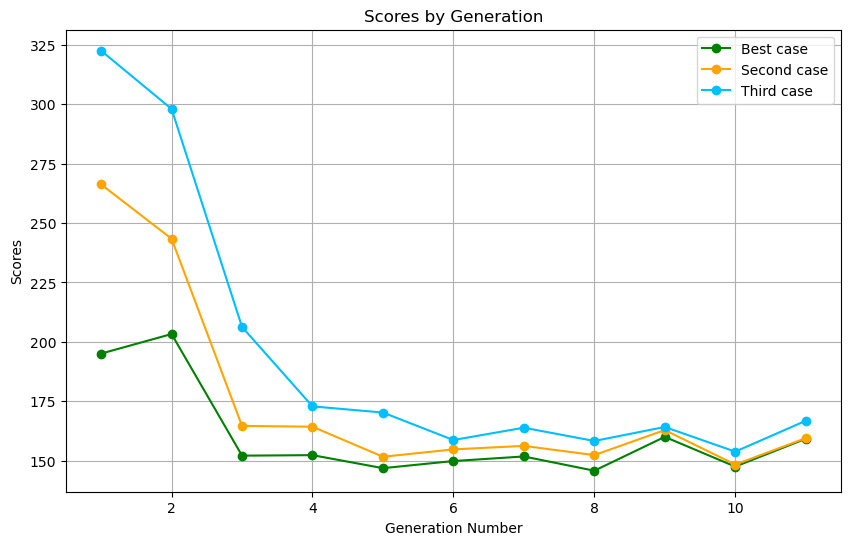

In [166]:
plot_scores(sample_history)